# Comparison between the Analytical and the Learning-based approach

## Imports and constants

In [33]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd

import pyroomacoustics as pra
from pyroomacoustics.transform import stft

SAMPLES = 2048
STEP = 1024

GRID = 180
ANGLE = 40

AUDIO_PATH = f'..\\data\\half_circle\\0.001\\test_angle_{ANGLE}_dist_200_room_medium_arctic_a0200.wav'

## Utils

In [34]:
fs, wav_signals = wavfile.read(AUDIO_PATH)

## Functions

In [35]:
# MUSIC
# Calculate Short-time Fourier transform and return
overlap = 256 // 2
fft = 256

observation = stft.analysis(wav_signals, L=fft, hop=overlap)
X = np.transpose(observation, axes=[2, 1, 0])

mic_pos=np.c_[[7/2+0.1, 0, 0],[7/2-0.1, 0, 0]] 
doa = pra.doa.MUSIC(mic_pos, fs, nfft=fft, n_grid=(GRID // 10), num_src=1)
doa.locate_sources(X)
pred = doa.azimuth_recon[0] 

spatial_resp = doa.grid.values
min_val = spatial_resp.min()
max_val = spatial_resp.max()
spatial_resp = (spatial_resp - min_val) / (max_val - min_val)
phi_plt = doa.grid.azimuth / 2
c_phi_plt = np.r_[phi_plt, phi_plt[0]]
c_dirty_img = np.r_[spatial_resp, spatial_resp[0]]

In [36]:
# CNN
CNN = pd.read_csv('../comparison/CNN_spectrum.csv')
data = np.array([])

for i in range(len(CNN)):
    if CNN.loc[i, 'y_true'] == ANGLE:
        data = np.append(data, CNN['y_pred'][i])

# Get the spectrum
angle_pp = list(range(0, GRID + 1, 10))
instance = np.array([])
CNN_spectrum = np.array([])

for angle in angle_pp:
    instance = np.append(instance, np.count_nonzero(data == angle))

min_val = np.min(instance)
max_val = np.max(instance)
norm_array = (instance - min_val) / (max_val - min_val)

## Visualize comparison

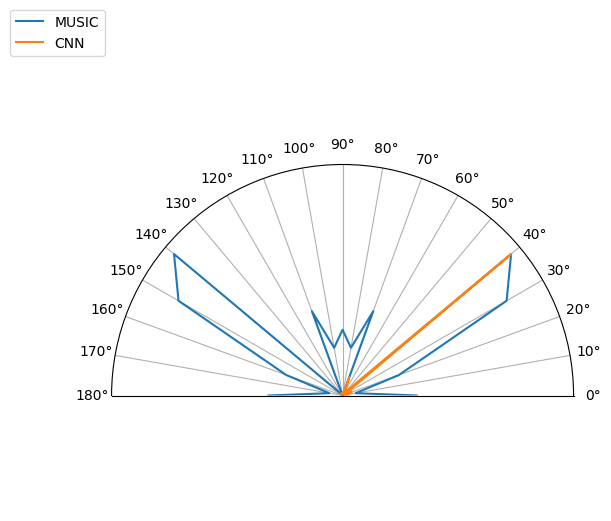

In [38]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(polar=True)

# Set the theta values from 0 to pi
theta = np.linspace(0, (GRID*np.pi/180), num=19)

# Plot the circle
ax.plot(theta, c_dirty_img, label='MUSIC')
ax.plot(theta, norm_array, label='CNN')

# Set the labels and title of the plot
ax.set_thetamin(0)
ax.set_thetamax(180)
ax.set_thetagrids(range(0, GRID + 1, 10)) # set the gridlines
ax.set_rticks([])

# Add a legend
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc=0, ncol=1, bbox_to_anchor=(0, 1.1))

plt.show()

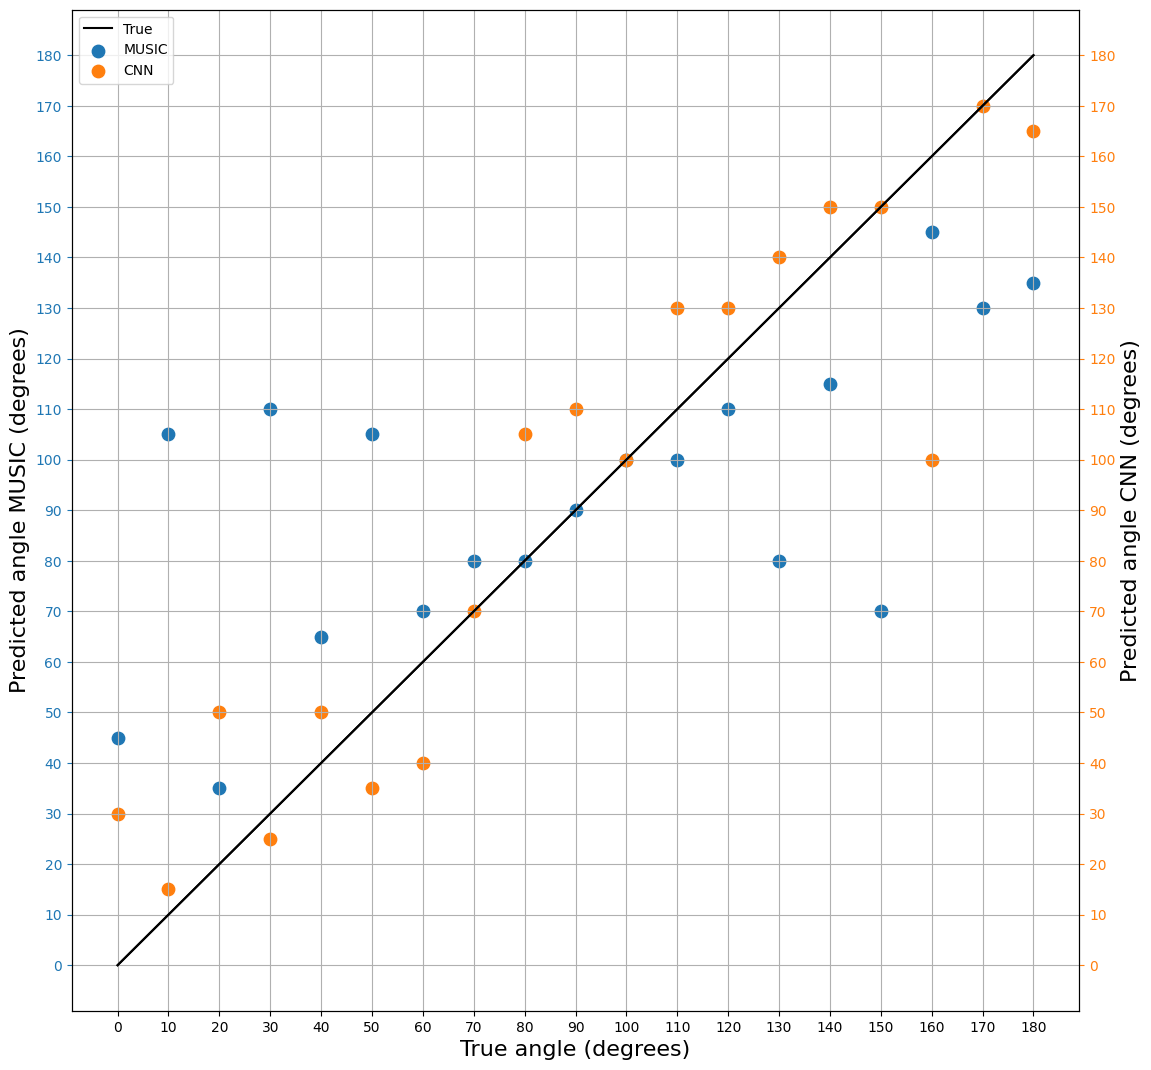

In [39]:
# Generate data for the x-axis
x = list(range(0, GRID + 1, 10))

# Generate data for the y-axes
MUSIC = pd.read_csv('../comparison/MUSIC_data.csv')
CNN = pd.read_csv('../comparison/CNN_data.csv')

# Create the figure and subplots
fig, ax1 = plt.subplots(figsize=(13, 13))

# Create a second y-axis on the right side
ax2 = ax1.twinx()

# Plot the data on each axis
ax1.plot(x, x, color='black', label='True')
ax2.plot(x, x, color='black')
MUSIC.plot.scatter(x="y_true", y="y_pred", ax=ax1, s=80, color='C0', label='MUSIC')
CNN.plot.scatter(x="y_true", y="y_pred", ax=ax1, s=80, color='C1', label='CNN')

# Set the limits and labels for each axis
ax1.set_xticks(list(range(0, GRID + 1, 10)))
ax1.set_yticks(list(range(0, GRID + 1, 10)))
ax2.set_yticks(list(range(0, GRID + 1, 10)))

ax1.set_xlabel('True angle (degrees)', fontsize=16)
ax1.set_ylabel('Predicted angle MUSIC (degrees)', fontsize=16)
ax2.set_ylabel('Predicted angle CNN (degrees)', fontsize=16)

ax1.tick_params(axis='y', colors='C0')
ax2.tick_params(axis='y', colors='C1')

# Add a legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left', ncol=1)

# Add a grid
ax1.grid(True)

# Display the plot
plt.show()